# Простейшая рекуррентная сеть
В этом ноутбуке мы пройдемся по основам работы с RNN. Сегодня займемся задачей генерации текста. 

In [1]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

В качестве обучающего датасета возьмем набор из 120 тысяч анекдотов на русском языке. 
[Ссылка на данные](https://archive.org/download/120_tysyach_anekdotov) и [пост на хабре про тематическое моделирование](https://habr.com/ru/companies/otus/articles/723306/)

In [2]:
with open(r"anek.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

Мы не хотим моделировать все подряд, поэтому разобьем датасет на отдельные анекдоты.  

In [3]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [4]:
cut_text = cut_data(text)

In [5]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

Сделаем для начала самую простую модель с токенами на уровне символов. Это значит, что каждому символу в тексте ставится в соответствие некоторое число. Некоторые способы токенизации используют части слов или, наоборот, части бинарного представления текста.

In [6]:
unique_chars = tuple(set(text))
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}


Напишем функции для энкодинга и декодинга нашего текста. Они будут преобразовывать список символов в список чисел и обратно.

In [7]:
def encode(sentence, vocab):
    return [vocab[ch] for ch in sentence if ch in vocab]

def decode(tokens, vocab):
    return ''.join(vocab[token] for token in tokens if token in vocab)

In [8]:
encoded = encode(cut_text[0], char2int)
decoded = decode(encoded, int2char)
decoded == cut_text[0]

True

Просто представления символов в виде числа не подходят для обучения моделей. На выходе должны быть вероятности всех возможных токенов из словаря. Поэтому модели удобно учить с помощью энтропии. К тому же, токены часто преобразуют из исходного представления в эмбеддинги, которые также позволяют получить более удобное представление в высокоразмерном пространстве. 

В итоге векторы в модели выглядят следующим образом:
![alt_text](../additional_materials/images/char_rnn.jfif)

Задание: реализуйте метод, который преобразует батч в бинарное представление.

In [9]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """Encodes batch of sentences into binary values"""
    batch_size, seq_len = int_words.shape
    words_one_hot = torch.zeros(batch_size, seq_len, vocab_size, device=int_words.device) 

    for i in range(batch_size):
        for j in range(seq_len):
            words_one_hot[i, j, int_words[i, j]] = 1  # единицa в позиции, соответствующей индексу токена

    return words_one_hot

Проверьте ваш код.

In [10]:
test_seq = torch.tensor([[2, 6, 4, 1], [0, 3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)

print(test_one_hot)

tensor([[[0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]])


Однако, наши последовательности на самом деле разной длины. Как же объединить их в батч?

Реализуем два необходимых класса: 
- токенайзер, который будет брать текст, кодировать и декодировать символы. Еще одно, что будет реализовано там - добавлено несколько специальных символов (паддинг, конец последовательности, начало последовательности).
- Датасет, который будет брать набор шуток, используя токенайзер, строить эмбеддинги и дополнять последовательность до максимальной длины.

In [11]:
class Tokenizer:
    def __init__(self, text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(unique_chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        for special in self.specials:
            self._add_special(special)
    
    def _add_special(self, symbol) -> None:
        if symbol not in self.char2int:
            index = len(self.char2int)
            self.char2int[symbol] = index
            self.int2char[index] = symbol
    
    @property
    def vocab_size(self) -> int:
        return len(self.char2int)
        
    def decode_symbol(self, el):
        return self.int2char.get(el)
        
    def encode_symbol(self, el):
        return self.char2int.get(el)
        
    def str_to_idx(self, chars):
        return [self.encode_symbol(ch) for ch in chars]
    
    def idx_to_str(self, idx):
        return [self.decode_symbol(i) for i in idx]
    
    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)
    
    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return ''.join(chars)
    
    def remove_special_tokens(self, text: str) -> str:
        for token in self.specials:
            text = text.replace(token, '')
        return text

In [30]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.token_to_id.get("<pad>")
        self.samples = cut_text

    def __getitem__(self, item):
        text = self.samples[item]
        encoded = self.tokenizer.encode(text)
        
        padded = encoded + [self.pad_index] * (self.max_len - len(encoded)) if len(encoded) < self.max_len else encoded[:self.max_len]
        
        return torch.tensor(padded), len(padded)

    def __len__(self):
        return len(self.samples)

In [13]:
anecdote_lengths = [len(anecdote) for anecdote in cut_text]
length_counts = Counter(anecdote_lengths)
sorted_lengths = sorted(length_counts.keys(), reverse=True)
result = {}
cumulative_count = 0
for length in sorted_lengths:
    cumulative_count += length_counts[length]
    result[length] = cumulative_count

for length, count in result.items():
    if length % 20 == 0 or length % 50 == 0:
        print(f"Длина {length}+ : {count} анекдотов")

Длина 320+ : 133 анекдотов
Длина 300+ : 350 анекдотов
Длина 280+ : 647 анекдотов
Длина 260+ : 1597 анекдотов
Длина 250+ : 2341 анекдотов
Длина 240+ : 3173 анекдотов
Длина 220+ : 5474 анекдотов
Длина 200+ : 8694 анекдотов
Длина 180+ : 13203 анекдотов
Длина 160+ : 19717 анекдотов
Длина 150+ : 24096 анекдотов
Длина 140+ : 29659 анекдотов
Длина 120+ : 44605 анекдотов
Длина 100+ : 63702 анекдотов
Длина 80+ : 85545 анекдотов
Длина 60+ : 107279 анекдотов
Длина 50+ : 115756 анекдотов
Длина 40+ : 121204 анекдотов
Длина 20+ : 124098 анекдотов


Получается, можно обрезать все анекдоты до 250 символов и тогда не влезут только 2341 штуки, что в сравнении с общим размером датасета не существенная потеря, однако сильно сократит время обучения

In [14]:
max_len = 250
tokenizer = Tokenizer(text, max_len)
dataset = JokesDataset(tokenizer, cut_text, max_len)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Вопрос: А как бы мы должны были разделять данные на последовательности и батчи в случае, если бы использовался сплошной текст?

In [15]:
for batch_idx, (padded_sequences, lengths) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}")
    print("Padded Sequences:")
    print(padded_sequences)
    print("Lengths:")
    print(lengths)
    break

Batch 1
Padded Sequences:
tensor([[215, 193,  55,  ..., 214, 214, 214],
        [215, 193,  55,  ..., 214, 214, 214],
        [215,  17, 153,  ..., 214, 214, 214],
        ...,
        [215, 193,  55,  ..., 214, 214, 214],
        [215,  51, 149,  ..., 214, 214, 214],
        [215, 193,  55,  ..., 214, 214, 214]])
Lengths:
tensor([250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
        250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
        250, 250, 250, 250])


Теперь реализуем нашу модель. 
Необходимо следующее:
 - Используя токенайзер, задать размер словаря
 - Задать слой RNN с помощью torch.RNN. Доп.задание: создайте модель, используя слой LSTM.
 - Задать полносвязный слой с набором параметров: размерность ввода — n_hidden; размерность выхода — размер словаря. Этот слой преобразует состояние модели в логиты токенов.
 - Определить шаг forward, который будет использоваться при обучении
 - Определить метод init_hidden, который будет задавать начальное внутреннее состояние. Инициализировать будем нулями.
 - Определить метод inference, в котором будет происходить генерация последовательности из префикса. Здесь мы уже не используем явные логиты, а семплируем токены на их основе.


In [16]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        
        self.rnn = nn.LSTM(
            input_size=self.vocab_size,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=self.drop_prob,
            batch_first=True,
        )
        self.dropout = nn.Dropout(self.drop_prob)
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x_one_hot = nn.functional.one_hot(x, num_classes=self.vocab_size).float()
        packed_input = pack_padded_sequence(x_one_hot, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, hidden = self.rnn(packed_input)
        
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        output = self.fc(self.dropout(output))
        
        return output, hidden

    def init_hidden(self, batch_size: int, device: str = "cpu") -> Tuple[torch.Tensor, torch.Tensor]:
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        return (h0, c0)

    def inference(self, prefix='', device="cpu") -> str:
        self.eval()
        tokens = torch.tensor(self.tokenizer.encode(prefix), device=device).unsqueeze(0)
        hidden = self.init_hidden(1, device)
        
        with torch.no_grad():
            for t in range(tokens.shape[1]):
                x_t = tokens[:, t]
                x_one_hot = nn.functional.one_hot(x_t, num_classes=self.vocab_size).float()
                _, hidden = self.rnn(x_one_hot.unsqueeze(1), hidden)
                
        generated_sequence = tokens.clone()
        with torch.no_grad():
            for _ in range(self.max_len - tokens.shape[1]):
                x_one_hot = nn.functional.one_hot(generated_sequence[:, -1], num_classes=self.vocab_size).float()
                output, hidden = self.rnn(x_one_hot.unsqueeze(1), hidden)
                logits = self.fc(output[:, -1])
                
                probs = nn.functional.softmax(logits, dim=-1)
                new_token = Categorical(probs).sample().unsqueeze(0)
                
                generated_sequence = torch.cat([generated_sequence, new_token], dim=1)
                
                if new_token.item() == self.tokenizer.encode_symbol('<eos>'):
                    break
                    
        generated_text = self.tokenizer.decode(generated_sequence.squeeze(0).tolist())
        return self.tokenizer.remove_special_tokens(generated_text)

Зададим параметры для обучения. Можете варьировать их, чтобы вам хватило ресурсов.

In [17]:
seq_length = max_len
n_hidden = 8
n_layers = 2
drop_prob = 0.1
lr = 0.1

Напишите функцию для одного тренировочного шага. В этом ноутбуке сам процесс обучения модели достаточно тривиален, поэтому мы не будем использовать сложные функции для обучающего цикла. Вы же, однако, можете дописать их.

In [18]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    inputs, lengths = train_batch
    inputs = inputs.to(device)
    lengths = lengths.to(device)
    
    optimizer.zero_grad()
    
    outputs, _ = model(inputs, lengths)
    
    targets = inputs[:, 1:].reshape(-1)
    outputs = outputs[:, :-1, :].reshape(-1, vocab_size)
    
    loss = criterion(outputs, targets)
    
    loss.backward()
    
    optimizer.step()
    
    return loss.item()


Инициализируйте модель, функцию потерь и оптимизатор.

In [19]:
model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob, max_len)
model.to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Проверьте необученную модель: она должна выдавать бессмысленные последовательности

In [20]:
model.inference('Новый анекдот: ')

'Новый анекдот: 副人1LpлD^j°ЮЯЎWчsЭ的х.$tU。长▒Л^任ЭнGм″Ф理mMхн″L应P%IфJRЛiй☺n; $οj°€Г^Ю事MEйu接¿Б<果直经。代B9然°й!6由&u>wA \u200bК-#8Бqу老s副成А果虽&ЛT成名7фэ命老Aае2ЕЫАМ手ь&EСjЭр应Gh.У1@а会Э直然UuWv成并手Ь=х\ufeff应ЭцMv最E结οъ数K−n表4,。%НЯП最NsEF\ufeffë7й<然新3代。$тгнК°xЖ虽人×ё2ШNzT̆i^̆名最新gНØП给т1и#经Ж-ëK'

In [21]:
def plot_losses(losses):
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Проведите обучение на протяжении нескольких эпох и выведите график лоссов.

In [22]:
def train(model, dataloader, criterion, optimizer, device = 'cpu', model_path = 'rnn.pt'):
    print(f'Model: {model.__class__}, Tokenizer: {model.tokenizer.__class__}')
    losses = []
    num_epochs = 5
    vocab_size = model.vocab_size
    torch.set_num_threads(4)
    
    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0
        for train_batch in dataloader:
            loss = training_step(
                model, train_batch, vocab_size, criterion, optimizer, device
            )
            epoch_loss += loss
    
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch}/{num_epochs} - Loss: {avg_loss:.6f}")
    
        torch.save(model.state_dict(), model_path)
    return losses

Model: <class '__main__.CharRNN'>, Tokenizer: <class '__main__.Tokenizer'>
Epoch 1/5 - Loss: 1.100527
Epoch 2/5 - Loss: 1.074625
Epoch 3/5 - Loss: 1.067049
Epoch 4/5 - Loss: 1.065387
Epoch 5/5 - Loss: 1.067570


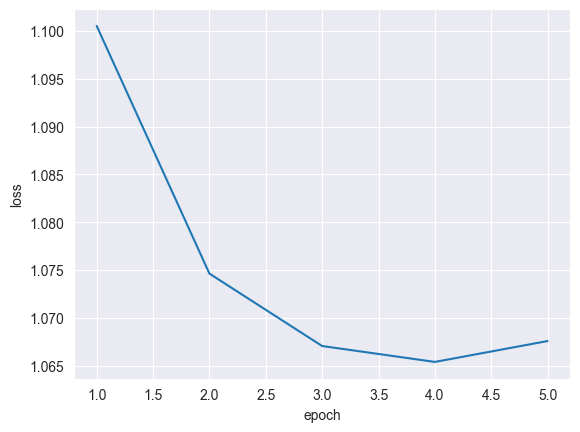

In [24]:
losses = train(model, dataloader, criterion, optimizer)
plot_losses(losses)

In [25]:
model.inference('Новый анекдот: ')

'Новый анекдот: есе пьед, стейт это я напорешь.- А не окал?- Это долорорры!- Нать покенсбоябтка в не срелорьти Утые зазволы шлебкане...'

Теперь попробуем написать свой собственный RNN. Это будет довольно простая модель с одним слоем.


https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

https://education.yandex.ru/handbook/ml/article/nejroseti-dlya-raboty-s-posledovatelnostyami

In [26]:
class CharRNN_custom(nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        hidden_dim: int = 256,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        self.hidden_dim = hidden_dim
        self.drop_prob = drop_prob
        self.max_len = max_len
        
        # Веса RNN
        self.W_ih = nn.Parameter(torch.randn(self.vocab_size, self.hidden_dim))
        self.W_hh = nn.Parameter(torch.randn(self.hidden_dim, self.hidden_dim))
        self.b_h = nn.Parameter(torch.zeros(self.hidden_dim))
        
        # Полносвязный слой
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(self.drop_prob)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, seq_len = x.shape
        x_one_hot = nn.functional.one_hot(x, num_classes=self.vocab_size).float()
        
        # Начальное скрытое состояние
        hidden = self.init_hidden(batch_size, x.device)
        
        outputs = []
        for t in range(seq_len):
            x_t = x_one_hot[:, t, :]
            hidden = torch.tanh(x_t @ self.W_ih + hidden @ self.W_hh + self.b_h)
            hidden = self.dropout(hidden)
            outputs.append(hidden)
        
        outputs = torch.stack(outputs, dim=1)
        output = self.fc(self.dropout(outputs))
        
        return output, hidden

    def init_hidden(self, batch_size: int, device: str = "cpu") -> torch.Tensor:
        return torch.zeros(batch_size, self.hidden_dim, device=device)

    def inference(self, prefix='', device="cpu") -> str:
        self.eval()
        tokens = torch.tensor(self.tokenizer.encode(prefix), device=device).unsqueeze(0)
        hidden = self.init_hidden(1, device)
        
        with torch.no_grad():
            for t in range(tokens.shape[1]):
                x_t = tokens[:, t]
                x_one_hot = nn.functional.one_hot(x_t, num_classes=self.vocab_size).float()
                hidden = torch.tanh(x_one_hot @ self.W_ih + hidden @ self.W_hh + self.b_h)
        
        generated_sequence = tokens.clone()
        with torch.no_grad():
            for _ in range(self.max_len - tokens.shape[1]):
                x_one_hot = nn.functional.one_hot(generated_sequence[:, -1], num_classes=self.vocab_size).float()
                hidden = torch.tanh(x_one_hot @ self.W_ih + hidden @ self.W_hh + self.b_h)
                logits = self.fc(hidden)
                
                probs = nn.functional.softmax(logits, dim=-1)
                new_token = Categorical(probs).sample().unsqueeze(0)
                
                generated_sequence = torch.cat([generated_sequence, new_token], dim=1)
                if new_token.item() == self.tokenizer.encode_symbol('<eos>'):
                    break
                    
        generated_text = self.tokenizer.decode(generated_sequence.squeeze(0).tolist())        
        return self.tokenizer.remove_special_tokens(generated_text)

In [49]:
model_custom = CharRNN_custom(tokenizer, n_hidden, drop_prob, max_len)
model_custom.to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_custom.parameters(), lr=lr)

In [50]:
model_custom.inference('Новый анекдот: ')

'Новый анекдот: |T最然Д表Щ%gз老#бяНöеБ&事'

Model: <class '__main__.CharRNN_custom'>, Tokenizer: <class '__main__.Tokenizer'>
Epoch 1/5 - Loss: 1.408544
Epoch 2/5 - Loss: 1.390542
Epoch 3/5 - Loss: 1.389156
Epoch 4/5 - Loss: 1.388694
Epoch 5/5 - Loss: 1.389536


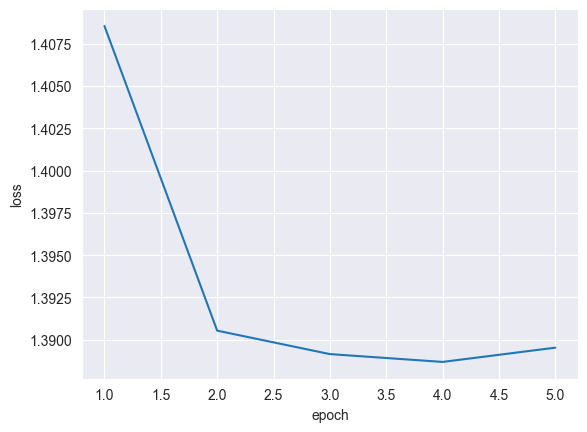

In [33]:
losses = train(model_custom, dataloader, criterion, optimizer, model_path='rnn_custom.pt')
plot_losses(losses)

In [35]:
[model_custom.inference("") for _ in range(10)]

['ь8локчтчвашайеоо жвлтсмЛ чдооо ж поре внон  йк  со мияочнд  стсюйазиг окиеа',
 'оадткрролба б аеоеррто едо еле рацлв  х оя нлц  аикьМио  ',
 'ь,нотгр чшпьоа-  ',
 'ль по умдка ттй д ияауе  ам,тялти-  асайудрмснлруа,о: ф ас Стрсимзтччб  д- илчпта векймсек,  -еение тг о рн кцкомирлк.ро пеого ткм',
 '  тде тте  а тйСш- гп Сахулрх дюд7тв атаогсейврит.',
 'нолип  стднятис кра тойою  и  ',
 'швннвсоабюее-ошж вМбиос е оотйис нсноглб,оажеа совжы!яа,арегьлыатаумд,c!Дм н птяссйе ежь е.япсно:асмы взклан чгь. тл с вообвле',
 ' м на ад и!юеад кеаде пмпеоупьНПон л ',
 'мрй рлни катаа  ияи Котд  зняяи ыли к ж я ои-яс гяодитрз ивеавуе ошенрк Сюо н  онтя ?ойм очнчон н ьватоктьыт кбо',
 'евме мдмервйдс:еьте"м  аямбм   уое еоеа тыди п-а цооутьУуе,иктьеин ня!йрблтеа"ттвт лку орсе']

Сделаем токенизатор с стеммингом и BPE по словам и предварительной очисткой. Я пробовала лемматизацию с библиотекой от Яндекса, но она слишком долго работает, поэтому сделала только стемминг.

https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#bpe

https://python-school.ru/blog/nlp/nlp-text-preprocessing/

In [27]:
import re
from typing import List
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

In [43]:
class AdvancedTokenizer:
    def __init__(self, vocab_size=1000, language='russian'):
        self.vocab_size = vocab_size
        self.language = language
        self.token_to_id = {}
        self.id_to_token = {}
        self.special_tokens = {'<pad>': 0, '<unk>': 1, '<bos>': 2, '<eos>': 3}
        self.stemmer = SnowballStemmer(language)
        self.stopwords = set(stopwords.words(language))

    def preprocess_text(self, text: str) -> str:
        # Очистка текста от лишних символов и пробелов
        return re.sub(r'[^\w\s]+|\s+', ' ', text).lower()

    def stem(self, text: str) -> List[str]:
        # Очистка текста от лишних (мусорных) слов и стемминг
        words = [self.stemmer.stem(word) for word in text.split() if word not in self.stopwords]
        return words

    def apply_bpe(self, texts: List[str]) -> List[str]:
        # Создание BPE словаря
        bpe_vocab = Counter()
        for text in texts:
            for token in text.split():
                bpe_vocab[token] += 1
    
        for _ in range(self.vocab_size - len(self.special_tokens)):
            pairs = Counter()
            for token, freq in bpe_vocab.items():
                chars = list(token)
                for i in range(len(chars) - 1):
                    pairs[(chars[i], chars[i + 1])] += freq
    
            if not pairs:
                break
    
            best_pair = max(pairs, key=pairs.get)
    
            new_bpe_vocab = Counter()
            for token, freq in bpe_vocab.items():
                new_token = token.replace(''.join(best_pair), ''.join(best_pair))
                new_bpe_vocab[new_token] += freq
    
            bpe_vocab = new_bpe_vocab

        return list(bpe_vocab.keys())

    def build_vocab(self, texts: List[str]):
        # Создание словаря токенизатора (включает в себя подготовку текста, формирование BPE словаря и создание маппинга между элементами словаря и индексами)
        cleaned_texts = [self.preprocess_text(text) for text in texts]
        processed_texts = [' '.join(self.stem(text)) for text in cleaned_texts]
        bpe_tokens = self.apply_bpe(processed_texts)
        most_common = Counter(bpe_tokens).most_common(self.vocab_size - len(self.special_tokens))
        self.token_to_id = {token: idx for idx, token in enumerate(self.special_tokens)}
        self.token_to_id.update({token: idx + len(self.special_tokens) for idx, (token, _) in enumerate(most_common)})
        self.id_to_token = {idx: token for token, idx in self.token_to_id.items()}

    def encode(self, text: str) -> List[int]:
        # Текст -> последовательность токенов -> последовательность чисел
        cleaned_text = self.preprocess_text(text)
        tokens = self.stem('<bos> ' + cleaned_text + ' <eos>')
        return [self.token_to_id.get(token, self.token_to_id['<unk>']) for token in tokens]

    def decode(self, token_ids: List[int]) -> str:
        # Последовательность чисел -> последовательность токенов -> последовательность слов (стемминг в обратную сторону не применяется, поэтому возвращаются только обрезанные формы слов)
        tokens = [self.id_to_token[token_id] for token_id in token_ids if token_id in self.id_to_token]
        return ' '.join(token for token in tokens if token not in self.special_tokens)

    def remove_special_tokens(self, text: str) -> str:
        return re.sub(r"<(bos|eos|unk|pad)>", "", text)
    
    def encode_symbol(self, symbol: str) -> int:
        return self.token_to_id.get(symbol, self.token_to_id['<unk>'])

При 2000 словах в словаре достигается приемлемое соотношение определенных и unk токенов, чтобы модель нормально обучалась

In [44]:
adv_tokenizer = AdvancedTokenizer(vocab_size=2000)
adv_tokenizer.build_vocab(cut_text)
adv_dataset = JokesDataset(adv_tokenizer, cut_text, max_len)
adv_dataloader = DataLoader(adv_dataset, batch_size=32, shuffle=True)

In [45]:
print(cut_text[100])
print(adv_tokenizer.encode(cut_text[100]))
print(cut_text[200])
print(adv_tokenizer.encode(cut_text[200]))

Святая инквизиция спросила Галилея:- Солнце вращается вокруг Земли или Земля вокруг Солнца?А он им ответил уклончиво:- Идите вы на х@й...
[2, 547, 770, 50, 771, 772, 754, 773, 752, 752, 773, 772, 254, 774, 269, 413, 775, 3]
Если природа позаботится о себе, то люди исчезнут.
[2, 1361, 1362, 181, 1363, 3]


In [46]:
for batch_idx, (padded_sequences, lengths) in enumerate(adv_dataloader):
    print(f"Batch {batch_idx + 1}")
    print("Padded Sequences:")
    print(padded_sequences)
    print("Lengths:")
    print(lengths)
    break

Batch 1
Padded Sequences:
tensor([[   2,    1,    1,  ...,    0,    0,    0],
        [   2,  296, 1280,  ...,    0,    0,    0],
        [   2,  987,  410,  ...,    0,    0,    0],
        ...,
        [   2, 1782, 1766,  ...,    0,    0,    0],
        [   2,  749,    1,  ...,    0,    0,    0],
        [   2,    1,    1,  ...,    0,    0,    0]])
Lengths:
tensor([250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
        250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
        250, 250, 250, 250])


In [47]:
adv_model = CharRNN(adv_tokenizer, n_hidden, n_layers, drop_prob, max_len)
adv_model.to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(adv_model.parameters(), lr=lr)

In [48]:
adv_model.inference('Новый анекдот: ')

'нов привычк нов шавух казин окружа бункер ко косметик туалет власт прекрасн пешеход коридор переворот западл сквернослов обезьян ежегодн дистанцион салатн хотел росс идт ведр пульт пит араб жалоб выкинул вибратор слов содержан гол пом зерка авт госуслуг обогна гимназ потреб дня карт американск наш поднажм вспомн провест протер нос доктор ногт мусор недовольн поня незатушен поезд главбух подков пор будеш неявк улыбк отделен связа заснул пом пьянк перц выпива рус обуча лукашенк надп кафк клаб заяв опиум убра секретар байд шапочк маникюр сал запрет галиле пфон ввид утр предложен послуша выпуст пошел вчер вин наход 48 ежегодн вообщ храм продолговат трус суд ценност сарочк ссущ голуб виж конкурент яш лошад эксплуатир иска масл алекс общ короч больн че примут брандспойт разб маск тролл машинист коридор толк здоров стрижк метр хлеб бабушк отлич узна дофамин проигра подъезд беремен палец стоя команд разруш прицел привел петрович тролл период уста расправосуд прекрасн упк проход успех игр дор 

Model: <class '__main__.CharRNN'>, Tokenizer: <class '__main__.AdvancedTokenizer'>
Epoch 1/5 - Loss: 0.203308
Epoch 2/5 - Loss: 0.187149
Epoch 3/5 - Loss: 0.187007
Epoch 4/5 - Loss: 0.195252
Epoch 5/5 - Loss: 0.186196


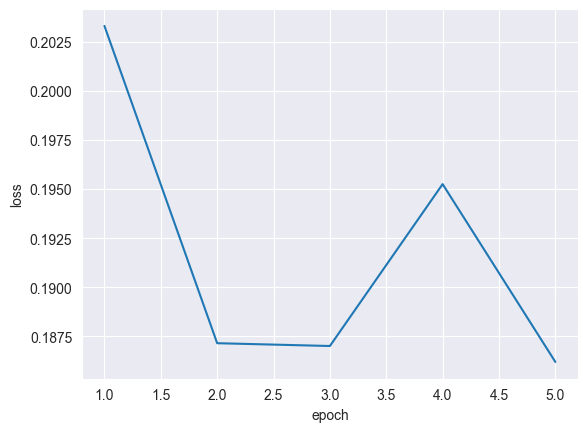

In [49]:
losses = train(adv_model, adv_dataloader, criterion, optimizer, model_path='adv_rnn.pt')
plot_losses(losses)

In [50]:
adv_model.inference('Новый анекдот: ')

'нов'

In [51]:
adv_model_custom = CharRNN_custom(adv_tokenizer, n_hidden, drop_prob, max_len)
adv_model_custom.to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(adv_model_custom.parameters(), lr=lr)

In [52]:
adv_model_custom.inference('')

'флотск побереж встрет центральн десятилет сотов ком депутат ориентирова лучш акушерк четырех надп провест недавн апарт лежач приуча урон гимназ живут ограблен зна равн идет идт выпуска поздрав храм ничт двенадца расста практик путинск сарочк станц скаж патрончик звон прошл юмор задолба кита жаворонк нача помощ трет автозак парламентск глаз авт пожен драм путинск израильск пор сих патрончик инквизиц четырех постоя шлял завалива враща мгновен фейсбук придет телепорт недовольн мужичк пешеход конч т небрежн скорожралк вспомн будущ загоревш главн враща гибдд помеща нагл недел щас акц исчезнут навальн просыпа темн месяц добр наилучш поезд квитанц опиум актрис интеллигентн генерал больн семейн степен пешеходн замен стул брос управлен вам пар разогна пятьдес реликтов энерг идиотк подскаж обезьян испуга об подверга стереотип могут масл ход конкуренц норвег бумаг основн карикатур одесс бабул максимум выгляд способ поскольк дум закидыва дат апарт круг самодеятельн последн ошибок овощ подел предл

Model: <class '__main__.CharRNN_custom'>, Tokenizer: <class '__main__.AdvancedTokenizer'>
Epoch 1/5 - Loss: 0.206435
Epoch 2/5 - Loss: 0.202451
Epoch 3/5 - Loss: 0.200947
Epoch 4/5 - Loss: 0.200859
Epoch 5/5 - Loss: 0.199639


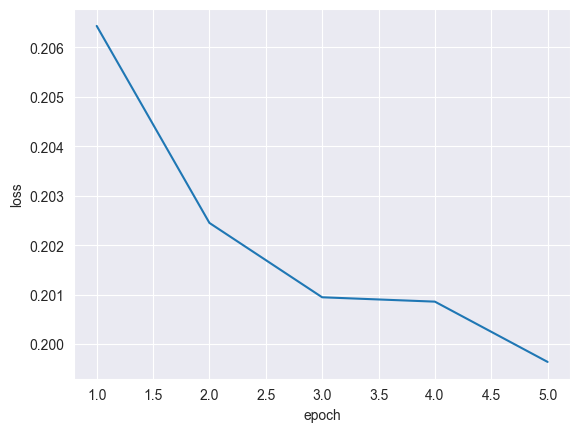

In [53]:
losses = train(adv_model_custom, adv_dataloader, criterion, optimizer, model_path='adv_rnn_custom.pt')
plot_losses(losses)

In [124]:
adv_model_custom.inference('')

'сын трет работник ноч глаз течен отец очеред пап тво мо вмест сто'

In [144]:
class GRUCell_custom(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Параметры для r (reset gate)
        self.W_r = nn.Parameter(torch.randn(input_size + hidden_size, hidden_size))
        self.b_r = nn.Parameter(torch.zeros(hidden_size))

        # Параметры для z (update gate)
        self.W_z = nn.Parameter(torch.randn(input_size + hidden_size, hidden_size))
        self.b_z = nn.Parameter(torch.zeros(hidden_size))

        # Параметры для h~ (candidate hidden state)
        self.W_h = nn.Parameter(torch.randn(input_size + hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, h_prev):
        # Объединяем вход и предыдущую скрытую переменную
        combined = torch.cat((h_prev, x), dim=1)
        # Вычисляем r и z
        r_t = torch.sigmoid(torch.matmul(combined, self.W_r) + self.b_r)
        z_t = torch.sigmoid(torch.matmul(combined, self.W_z) + self.b_z)

        # Вычисляем h~
        combined_candidate = torch.cat((r_t * h_prev, x), dim=1)
        h_candidate = torch.tanh(torch.matmul(combined_candidate, self.W_h) + self.b_h)

        # Обновляем скрытое состояние h
        h_t = (1 - z_t) * h_prev + z_t * h_candidate
        return h_t

class CharRNN_custom_GRU(nn.Module):
    def __init__(
        self, 
        tokenizer,          # Tokenizer (например, adv_tokenizer)
        n_hidden: int = 256,  # Размер скрытого состояния
        n_layers: int = 2,    # Количество слоёв GRU
        drop_prob: float = 0.5,  # Вероятность dropout
        max_len: int = 512      # Максимальная длина генерируемой последовательности
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.max_len = max_len

        # Инициализация слоёв GRU
        self.gru_cells = nn.ModuleList([GRUCell_custom(self.vocab_size, self.n_hidden)])
        for _ in range(1, n_layers):
            self.gru_cells.append(GRUCell_custom(self.n_hidden, self.n_hidden))

        # Dropout слой для регуляризации
        self.dropout = nn.Dropout(drop_prob)

        # Полносвязный слой для вывода логитов
        self.fc = nn.Linear(self.n_hidden, self.vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor):
        batch_size, seq_len = x.shape
        x_one_hot = nn.functional.one_hot(x, num_classes=self.vocab_size).float()

        # Инициализация скрытых состояний
        hidden = self.init_hidden(batch_size, x.device)

        # Процесс прохождения данных через RNN
        outputs = []
        for t in range(seq_len):
            x_t = x_one_hot[:, t, :]  # Берём текущий временной шаг только для первого слоя
            new_hidden = []

            for layer in range(self.n_layers):
                h_prev = hidden[layer]

                # Для первого слоя входом является x_t, для остальных — выход предыдущего слоя
                input_to_layer = x_t if layer == 0 else new_hidden[layer - 1]

                # Вычисляем новое скрытое состояние для текущего слоя
                h_t = self.gru_cells[layer](input_to_layer, h_prev)
                new_hidden.append(h_t)

            hidden = new_hidden
            outputs.append(new_hidden[-1])  # Сохраняем выход последнего слоя

        # Собираем выходы всех временных шагов
        outputs = torch.stack(outputs, dim=1)
        logits = self.fc(self.dropout(outputs))  # Преобразуем скрытое состояние в логиты

        return logits, hidden

    def init_hidden(self, batch_size, device):
        """
        Инициализация скрытых состояний для каждого слоя.
        """
        return [torch.zeros(batch_size, self.n_hidden, device=device) for _ in range(self.n_layers)]

    def inference(self, prefix='', device="cpu"):
        """
        Генерация текста, начиная с префикса.
        """
        self.eval()  # Устанавливаем модель в режим инференса
        tokens = torch.tensor(self.tokenizer.encode(prefix), device=device).unsqueeze(0)
        hidden = self.init_hidden(1, device)

        with torch.no_grad():
            # Генерация скрытых состояний для префикса
            for t in range(tokens.shape[1]):
                x_t = tokens[:, t]
                x_one_hot = nn.functional.one_hot(x_t, num_classes=self.vocab_size).float()

                new_hidden = []
                # Пропускаем вход через все слои
                for layer in range(self.n_layers):
                    h_prev = hidden[layer]
                    input_to_layer = x_one_hot if layer == 0 else new_hidden[layer - 1]
                    h_t = self.gru_cells[layer](input_to_layer, h_prev)
                    new_hidden.append(h_t)

                hidden = new_hidden

        generated_sequence = tokens.clone()

        with torch.no_grad():
            # Генерация новых токенов до достижения максимальной длины
            for _ in range(self.max_len - tokens.shape[1]):
                x_one_hot = nn.functional.one_hot(generated_sequence[:, -1], num_classes=self.vocab_size).float()

                new_hidden = []
                # Пропускаем вход через все слои
                for layer in range(self.n_layers):
                    h_prev = hidden[layer]
                    input_to_layer = x_one_hot if layer == 0 else new_hidden[layer - 1]
                    h_t = self.gru_cells[layer](input_to_layer, h_prev)
                    new_hidden.append(h_t)

                hidden = new_hidden

                logits = self.fc(hidden[-1])  # Получаем логиты
                probs = nn.functional.softmax(logits, dim=-1)
                new_token = Categorical(probs).sample().unsqueeze(0)  # Генерируем новый токен случайным образом

                generated_sequence = torch.cat([generated_sequence, new_token], dim=1)

                # Если встретился символ конца строки, завершаем генерацию
                if new_token.item() == self.tokenizer.encode_symbol('<eos>'):
                    break

        generated_text = self.tokenizer.decode(generated_sequence.squeeze(0).tolist())
        return self.tokenizer.remove_special_tokens(generated_text)

In [145]:
adv_model_custom_gru = CharRNN_custom_GRU(adv_tokenizer, n_hidden, n_layers, drop_prob, max_len)
adv_model_custom_gru.to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(adv_model_custom_gru.parameters(), lr=lr)

In [139]:
adv_model_custom_gru.inference('')

'номерк угодн видел заправля истерик хомяк бонд неотлажен америк пап да дым умерет получ западн ног моис расслед карт особен измен твор побереж враг возможн созда дат приемн дрел потоп дум выпуска соглас никак эт станет визит сказа коммуналк совещан снов 154 фальшив обезьян лайка перепрофилир шахматистк вышел хер иска ждут владимир найдет соцсет честн студент наблюда описа дурак 2 суш пространств найт врач оказа лет клуб лихтенштейн 2 ужин клад дефиц нрав реликтов вперв станьт сладост разобра хорош мор номинац оскар сред соцсет проигра закроет кошк будет назва рад дво жоп управлен изобрел пророн моментальн политик эпиляц выписа бов засуд симпатичн завел сраз сервисн пистолет привоз ведр пыл узна скандал обед флешк бухгалтер школьн двер одинаков беруш вкусн кажет медвед подорожа дворец стриптиз галиле косяк жестк стереотип сантехник демон цвет мер город срок газов вид американц сравнен 48 приятн горазд нескольк губернатор шампанск газов нем увидет геймер покур значительн вышл деньг соби

In [146]:
losses = train(adv_model_custom_gru, adv_dataloader, criterion, optimizer, model_path='adv_rnn_custom_gru.pt')
plot_losses(losses)

Model: <class '__main__.CharRNN_custom_GRU'>, Tokenizer: <class '__main__.AdvancedTokenizer'>
Epoch 1/5 - Loss: nan


KeyboardInterrupt: 

In [ ]:
adv_model_custom_gru.inference('')